In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "z"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.55it/s]

14it [00:00,  9.15it/s]

27it [00:00, 12.67it/s]

37it [00:00, 17.15it/s]

50it [00:00, 23.17it/s]

63it [00:00, 30.73it/s]

75it [00:00, 39.51it/s]

89it [00:00, 49.97it/s]

103it [00:00, 61.28it/s]

117it [00:01, 73.02it/s]

130it [00:01, 84.03it/s]

143it [00:01, 92.23it/s]

157it [00:01, 101.19it/s]

171it [00:01, 108.62it/s]

185it [00:01, 115.04it/s]

199it [00:01, 118.99it/s]

212it [00:01, 110.08it/s]

224it [00:01, 106.41it/s]

236it [00:02, 109.30it/s]

249it [00:02, 114.76it/s]

263it [00:02, 119.51it/s]

277it [00:02, 122.84it/s]

290it [00:02, 124.77it/s]

304it [00:02, 126.99it/s]

317it [00:02, 127.28it/s]

331it [00:02, 128.38it/s]

344it [00:02, 128.11it/s]

357it [00:03, 128.10it/s]

371it [00:03, 129.10it/s]

384it [00:03, 128.81it/s]

397it [00:03, 128.95it/s]

410it [00:03, 129.04it/s]

423it [00:03, 124.29it/s]

436it [00:03, 125.79it/s]

450it [00:03, 127.45it/s]

463it [00:03, 127.92it/s]

476it [00:03, 127.68it/s]

489it [00:04, 127.40it/s]

503it [00:04, 128.27it/s]

517it [00:04, 129.04it/s]

530it [00:04, 128.80it/s]

543it [00:04, 126.75it/s]

556it [00:04, 121.49it/s]

569it [00:04, 122.62it/s]

582it [00:04, 123.15it/s]

595it [00:04, 117.50it/s]

608it [00:05, 119.16it/s]

621it [00:05, 120.69it/s]

634it [00:05, 121.72it/s]

647it [00:05, 123.49it/s]

660it [00:05, 124.73it/s]

673it [00:05, 121.93it/s]

686it [00:05, 123.53it/s]

699it [00:05, 123.34it/s]

712it [00:05, 113.79it/s]

725it [00:06, 117.62it/s]

738it [00:06, 120.49it/s]

751it [00:06, 122.28it/s]

764it [00:06, 122.08it/s]

777it [00:06, 99.85it/s] 

790it [00:06, 105.62it/s]

802it [00:06, 107.42it/s]

814it [00:06, 102.09it/s]

825it [00:06, 103.27it/s]

839it [00:07, 110.55it/s]

852it [00:07, 113.33it/s]

864it [00:07, 100.38it/s]

876it [00:07, 103.52it/s]

889it [00:07, 108.57it/s]

902it [00:07, 113.20it/s]

915it [00:07, 117.21it/s]

928it [00:07, 119.77it/s]

941it [00:07, 119.96it/s]

954it [00:08, 113.91it/s]

966it [00:08, 109.49it/s]

978it [00:08, 96.55it/s] 

991it [00:08, 104.04it/s]

1005it [00:08, 110.84it/s]

1017it [00:08, 104.25it/s]

1031it [00:08, 110.83it/s]

1043it [00:08, 96.77it/s] 

1056it [00:09, 103.62it/s]

1069it [00:09, 109.57it/s]

1082it [00:09, 114.14it/s]

1095it [00:09, 116.88it/s]

1108it [00:09, 119.17it/s]

1121it [00:09, 120.65it/s]

1134it [00:09, 95.50it/s] 

1145it [00:09, 91.58it/s]

1157it [00:10, 97.09it/s]

1170it [00:10, 104.15it/s]

1183it [00:10, 109.73it/s]

1196it [00:10, 113.23it/s]

1208it [00:10, 101.17it/s]

1219it [00:10, 89.32it/s] 

1229it [00:10, 87.49it/s]

1239it [00:10, 86.82it/s]

1248it [00:10, 86.47it/s]

1259it [00:11, 91.58it/s]

1271it [00:11, 98.43it/s]

1284it [00:11, 104.72it/s]

1297it [00:11, 109.89it/s]

1310it [00:11, 113.78it/s]

1322it [00:11, 108.20it/s]

1335it [00:11, 112.23it/s]

1348it [00:11, 115.26it/s]

1361it [00:11, 118.58it/s]

1374it [00:12, 119.74it/s]

1387it [00:12, 119.52it/s]

1400it [00:12, 120.53it/s]

1413it [00:12, 120.61it/s]

1426it [00:12, 107.01it/s]

1438it [00:12, 109.15it/s]

1440it [00:12, 113.84it/s]


0it [00:00, ?it/s]

11it [00:00, 105.57it/s]

Number of empty sat catalogs is 0


24it [00:00, 109.66it/s]

37it [00:00, 114.78it/s]

50it [00:00, 118.23it/s]

62it [00:00, 117.13it/s]

75it [00:00, 120.53it/s]

89it [00:00, 123.37it/s]

103it [00:00, 125.73it/s]

116it [00:00, 126.34it/s]

130it [00:01, 127.64it/s]

143it [00:01, 128.06it/s]

157it [00:01, 128.69it/s]

171it [00:01, 129.28it/s]

184it [00:01, 128.83it/s]

197it [00:01, 128.86it/s]

210it [00:01, 128.45it/s]

224it [00:01, 129.78it/s]

238it [00:01, 131.31it/s]

252it [00:01, 131.80it/s]

266it [00:02, 133.24it/s]

280it [00:02, 133.42it/s]

294it [00:02, 133.75it/s]

308it [00:02, 133.76it/s]

322it [00:02, 130.25it/s]

336it [00:02, 132.57it/s]

350it [00:02, 133.72it/s]

364it [00:02, 134.52it/s]

378it [00:02, 130.63it/s]

392it [00:03, 132.86it/s]

406it [00:03, 126.08it/s]

420it [00:03, 128.90it/s]

434it [00:03, 131.24it/s]

448it [00:03, 116.70it/s]

461it [00:03, 107.87it/s]

473it [00:03, 108.74it/s]

487it [00:03, 115.37it/s]

501it [00:03, 120.93it/s]

515it [00:04, 125.37it/s]

529it [00:04, 127.09it/s]

543it [00:04, 128.48it/s]

556it [00:04, 128.91it/s]

570it [00:04, 130.18it/s]

584it [00:04, 131.06it/s]

598it [00:04, 132.18it/s]

612it [00:04, 132.33it/s]

626it [00:04, 130.52it/s]

640it [00:05, 127.48it/s]

654it [00:05, 129.00it/s]

668it [00:05, 130.04it/s]

682it [00:05, 112.13it/s]

694it [00:05, 105.01it/s]

705it [00:05, 100.00it/s]

718it [00:05, 105.76it/s]

732it [00:05, 113.30it/s]

746it [00:05, 118.06it/s]

760it [00:06, 122.28it/s]

774it [00:06, 124.70it/s]

788it [00:06, 127.49it/s]

801it [00:06, 118.69it/s]

815it [00:06, 123.37it/s]

829it [00:06, 126.46it/s]

843it [00:06, 128.94it/s]

857it [00:06, 125.39it/s]

871it [00:06, 127.28it/s]

885it [00:07, 129.45it/s]

899it [00:07, 129.31it/s]

912it [00:07, 128.56it/s]

926it [00:07, 130.23it/s]

940it [00:07, 131.76it/s]

954it [00:07, 127.75it/s]

968it [00:07, 129.68it/s]

982it [00:07, 132.05it/s]

996it [00:07, 132.68it/s]

1010it [00:08, 124.80it/s]

1024it [00:08, 127.85it/s]

1037it [00:08, 119.90it/s]

1050it [00:08, 117.51it/s]

1063it [00:08, 118.94it/s]

1075it [00:08, 108.20it/s]

1087it [00:08, 107.99it/s]

1101it [00:08, 114.84it/s]

1115it [00:08, 120.01it/s]

1128it [00:09, 122.58it/s]

1141it [00:09, 122.94it/s]

1155it [00:09, 125.48it/s]

1169it [00:09, 127.68it/s]

1182it [00:09, 113.23it/s]

1194it [00:09, 109.87it/s]

1208it [00:09, 116.39it/s]

1222it [00:09, 121.84it/s]

1236it [00:09, 125.36it/s]

1251it [00:10, 130.08it/s]

1265it [00:10, 132.71it/s]

1279it [00:10, 133.61it/s]

1293it [00:10, 133.61it/s]

1307it [00:10, 133.93it/s]

1321it [00:10, 133.53it/s]

1335it [00:10, 117.18it/s]

1348it [00:10, 107.45it/s]

1360it [00:10, 110.41it/s]

1374it [00:11, 117.28it/s]

1388it [00:11, 121.64it/s]

1401it [00:11, 121.74it/s]

1414it [00:11, 117.06it/s]

1428it [00:11, 121.68it/s]

1440it [00:11, 124.42it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

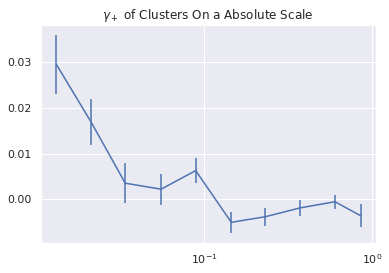

Aggregated xi:
[ -6.8923  -9.0382  -2.9015  -3.1884 -15.7101  21.008   24.1486  16.0272
   5.4494  13.0906]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1008.6805 -2057.4573 -2799.1906 -4201.6639 -6062.9564 -8007.9
 -9222.2593 -8354.4493 -4996.4379  -581.8349]
------------------------------------------------------------------------------
Aggregated npairs:
[ 233.  534.  827. 1452. 2505. 4144. 6295. 8466. 9746. 3608.]
------------------------------------------------------------------------------
Mean xi:
[-0.0296 -0.0169 -0.0035 -0.0022 -0.0063  0.0051  0.0038  0.0019  0.0006
  0.0036]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3291 -3.8529 -3.3848 -2.8937 -2.4203 -1.9324 -1.465  -0.9868 -0.5127
 -0.1613]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

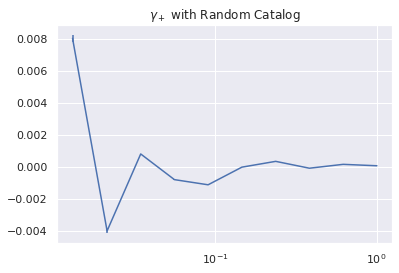

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1244e-04  1.0585e-04 -2.1341e-05  2.1083e-05  2.9603e-05  4.4573e-07
 -9.1272e-06  2.2006e-06 -4.1863e-06 -1.8362e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

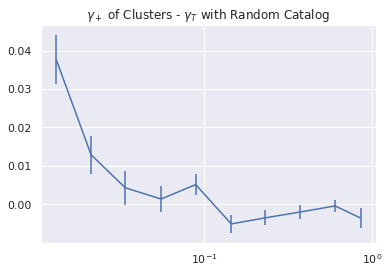

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

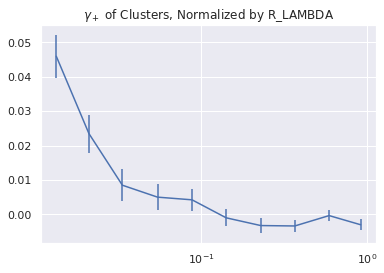

Aggregated xi:
[-5.8385 -8.4655 -5.8537 -5.3845 -8.1931  3.1565 16.8555 24.973   3.1128
 25.1973]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -547.0645 -1388.1439 -2337.3804 -3111.8338 -4680.5886 -6273.9661
 -7706.1597 -7488.206  -4964.1826  -777.156 ]
------------------------------------------------------------------------------
Aggregated npairs:
[ 127.  360.  689. 1071. 1928. 3210. 5219. 7451. 9381. 8409.]
------------------------------------------------------------------------------
Mean xi:
[-0.046  -0.0235 -0.0085 -0.005  -0.0042  0.001   0.0032  0.0034  0.0003
  0.003 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3076 -3.856  -3.3924 -2.9055 -2.4277 -1.9545 -1.4766 -1.005  -0.5292
 -0.0924]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)